In [1]:
from more_itertools import pairwise
import itertools
import igraph as ig
import random
import colorsys


In [2]:
ig.__version__

'0.9.8'

In [3]:
def to_stop_tuples(data_path):
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        # Skip first item, than pairwise
        for line1, line2 in pairwise(itertools.islice(lines, 1, None)):
            route_id, _, stop_seq1, stop_id1, _ = line1.split(';')
            route_id, _, stop_seq2, stop_id2, _ = line2.split(';')
            if stop_seq2 > stop_seq1:
                yield (route_id, stop_id1, stop_id2)


In [4]:
def get_stops(data_path):
    stops = dict()
    with open(data_path, 'rt') as f:
        # Remove empty line and new line tokens
        lines = filter(None, (line.rstrip() for line in f))
        for l in itertools.islice(lines, 1, None):  # Skip first item
            stop_id, _, stop_name, _, _, _, _, _, _ = l.split(',')
            stops[stop_id] = stop_name
    return stops

In [5]:
def rand_color():
    h, s, l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r, g, b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return (r / 255, g / 255, b / 255) 

In [6]:
# Tratte data
tratte_data = '../data/processed/tratte.csv'
tratte_tuple = ( (stop_id1, stop_id2) for _, stop_id1, stop_id2 in to_stop_tuples(tratte_data))


In [7]:
# Routes data
routes = { (stop_id1, stop_id2) : route_id for route_id, stop_id1, stop_id2 in set(to_stop_tuples(tratte_data)) }
# Routes color
routes_color = { route_id : rand_color() for route_id in set(routes.values()) }

In [8]:
# Create graph
g = ig.Graph.TupleList(set(tratte_tuple), directed=True)
g.summary()


'IGRAPH DN-- 428 1084 -- \n+ attr: name (v)'

In [9]:
# Stops data
stops_data = '../data/original/stops.txt'
stops = get_stops(stops_data)

In [10]:
# Vertex label = stop name
g.vs['label'] = [stops[stop_id] for stop_id in g.vs['name']]


In [11]:
g.es['label'] = [routes[(s['name'], o['name'])] for e in g.es if (s:=e.source_vertex ,o := e.target_vertex)]
g.es['color'] = [routes_color[route_id] for route_id in g.es['label']]

In [12]:
# Save the graph
g.write_graphml('../data/processed/trenord.graphml')

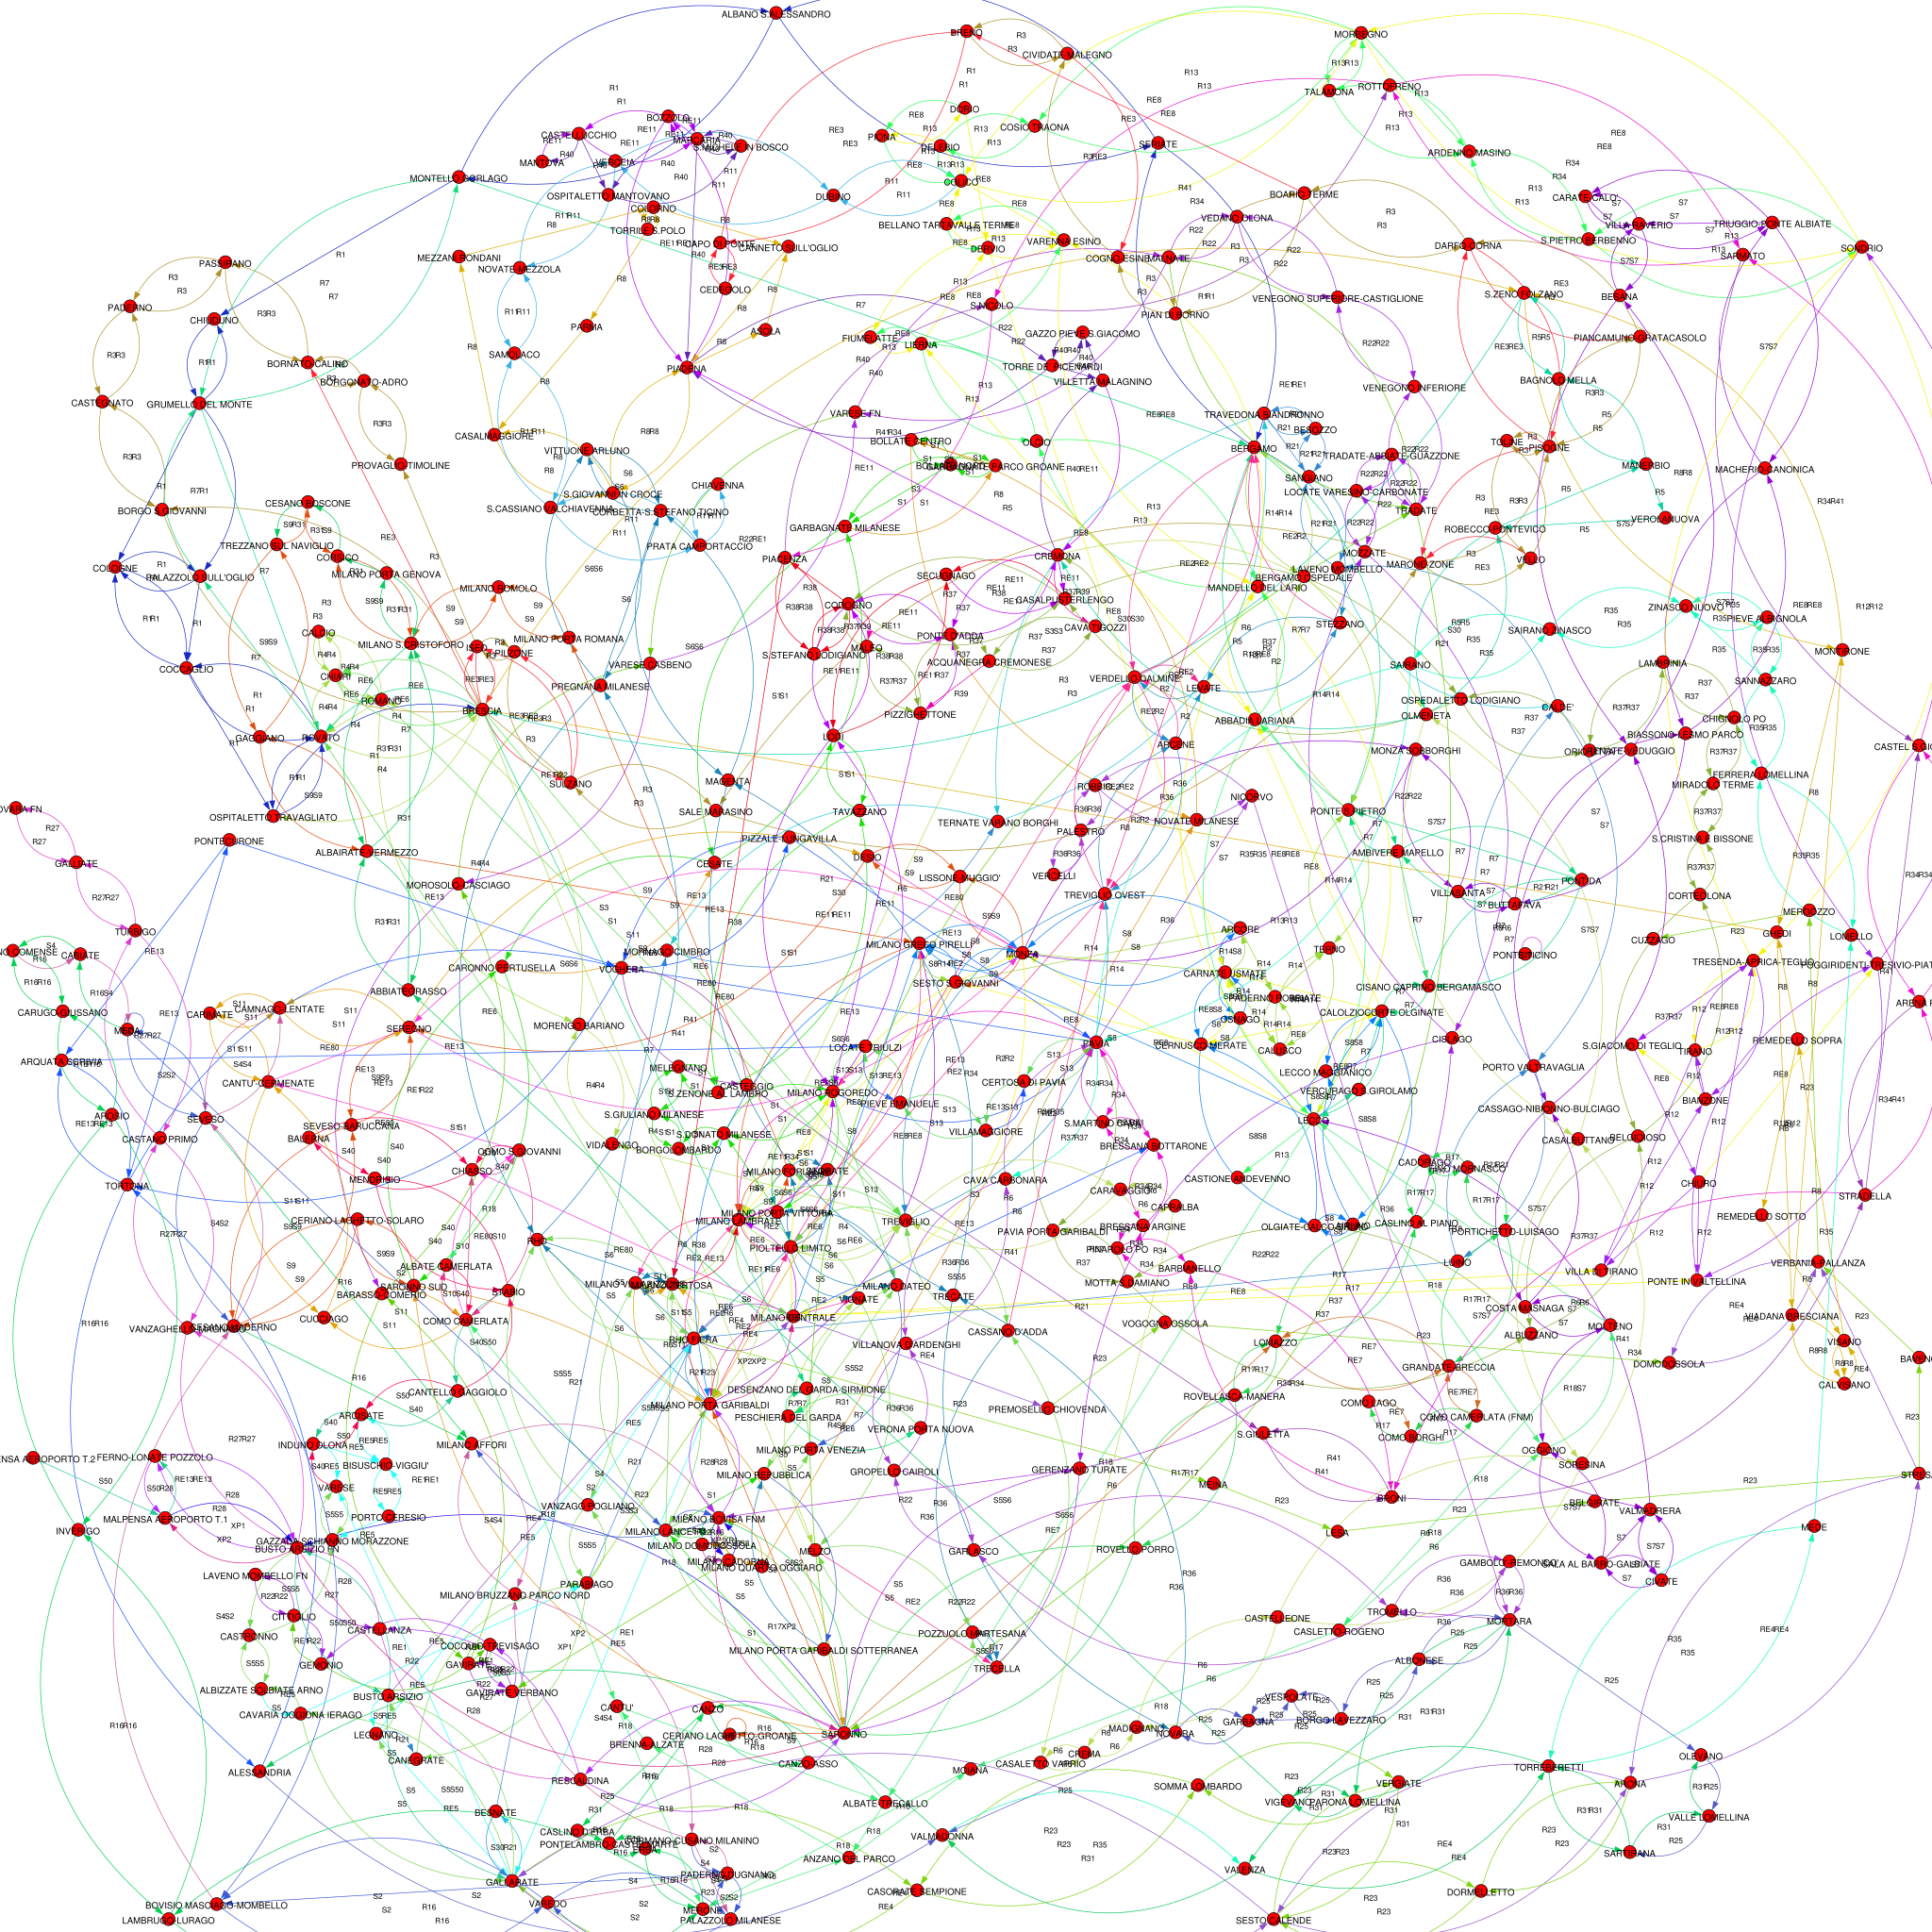

In [16]:
visual_style = {} #Python dictionary 
visual_style["layout"] = g.layout_auto()

ig.plot(g, bbox=(0, 0, 3000, 3000), **visual_style)